# Part 1

In [17]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np

model_path = "./model"  

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()  

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [2]:
import pickle

with open(r"C:\Users\mstan\OneDrive\Dokumenty\GitHub\2024-25c-fai2-adsai-group-group22_y2c\task 5\label_encoder.pkl", "rb") as file:
    label_encoder = pickle.load(file)


In [10]:
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

0 → anger
1 → disgust
2 → fear
3 → happiness
4 → neutral
5 → sadness
6 → surprise


In [4]:
sentences = {
    "neutral": [
        "Daniel Klusek, welcome to the Promenada studio. We're going.",
        "I mean I will swim. At the moment I am on a walk and we will swim at 2pm.",
        "Good morning."
    ],
    "happiness": [
        "Thank you for the interview.",
        "Thank you kindly.",
        "As tourists said, the sea is beautiful at any time of the year and so rough too. So let's look how beautiful it is. Or maybe you can still take a bath this summer."
    ],
    "surprise": [
        "What to do when you can't sunbathe and bathe? We will ask tourists about this.",
        "Where did you come from?",
        "Does the end of summer holidays mean the end of the season?"
    ],
    "disgust": [
        "The Lord knows that this is a jerk.",
        "Well, he can wish you not to start.",
        "Well, they are like that, because I understand that he is not right and just."
    ],
    "anger": [
        "It is a pity to bear it by mowing him in the ass.",
        "When I look at him that this is a bandit, not a minister.",
        "That he robs me because he gives me what they haven't worked after 35 years like me."
    ],
    "fear": [
        "The Swedish, Soviet invasion will survive.",
        "But there is aggression in this man.",
        "And today there is even nowhere to hide"
    ],
    "sadness": [
        "Not beach is the weather, although the sun comes out, but not enough to sunbathing until today.",
        "Well, but in the morning the rain was a bit.",
        "When he was after a carol, he cried and said that just what was happening in the church now,"
    ]
}


In [5]:
import torch
import matplotlib.pyplot as plt
from captum.attr import InputXGradient


def visualize_gradient_input(model, tokenizer, text, label=None):
    model.zero_grad()
    
    # Tokenize and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Get embedding layer
    embedding_layer = model.get_input_embeddings()
    embeddings = embedding_layer(input_ids)
    embeddings.retain_grad()

    # Forward pass
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    pred = torch.argmax(outputs.logits, dim=1)

    # Target class: use predicted class or provided label
    target_class = label if label is not None else pred.item()

    # Backward pass
    loss = outputs.logits[0, target_class]
    loss.backward()

    # Gradient × Input
    grads = embeddings.grad
    grad_times_input = grads * embeddings
    relevance_scores = grad_times_input.sum(dim=-1).squeeze().detach()

    # Decode tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    # Plot
    plt.figure(figsize=(12, 4))
    plt.bar(tokens, relevance_scores)
    plt.xticks(rotation=45)
    predicted_label = label_encoder.inverse_transform([target_class])[0]
    plt.title(f"Gradient × Input Relevance for: \"{text}\" (Predicted: {predicted_label})")
    plt.tight_layout()
    plt.show()


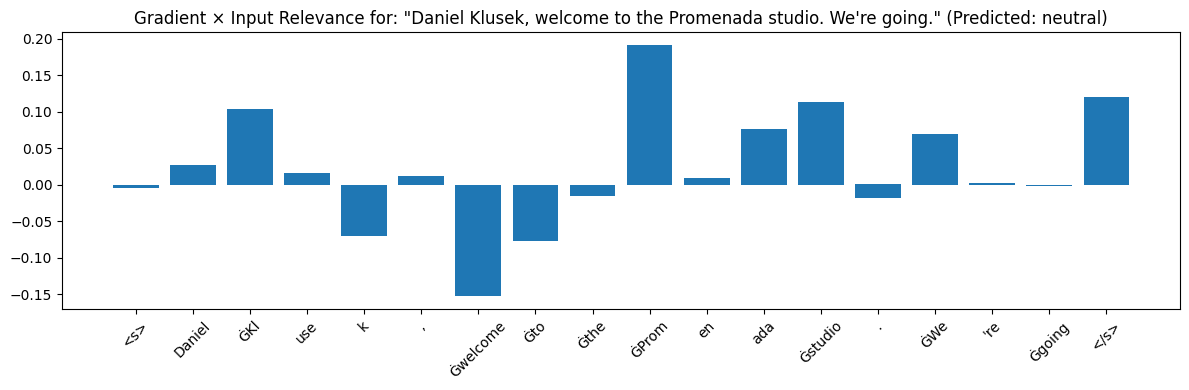

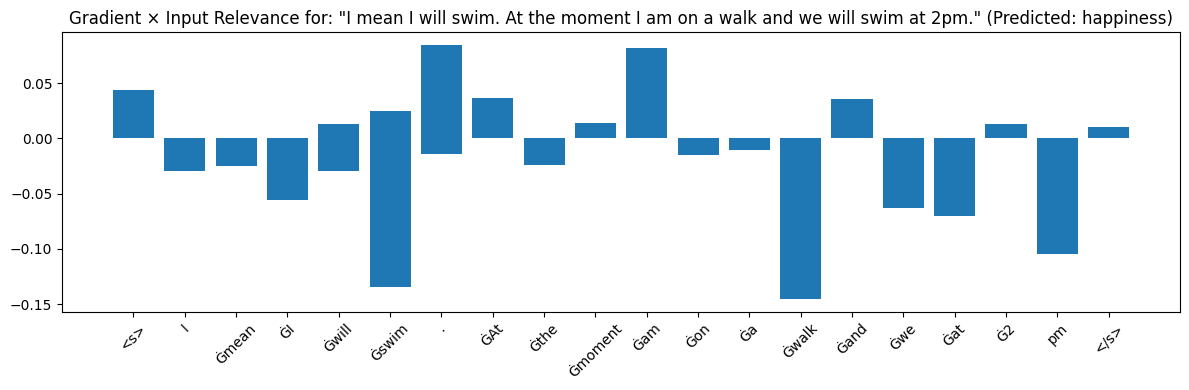

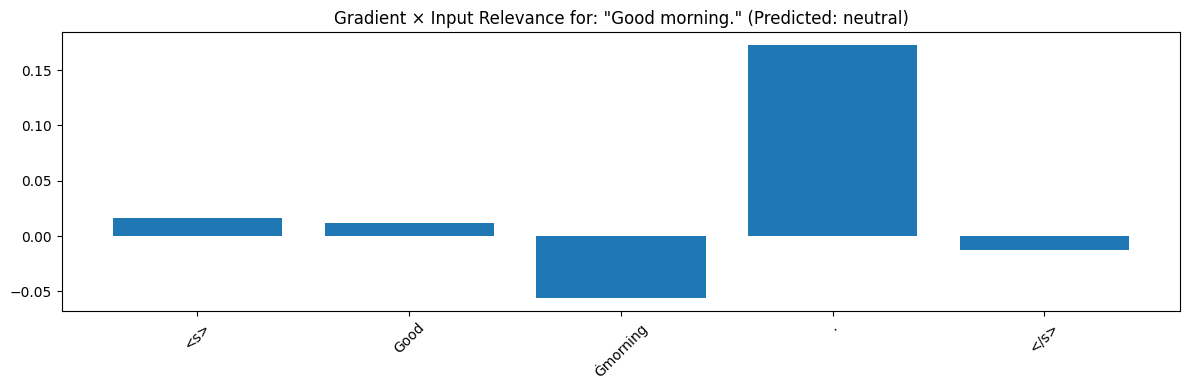

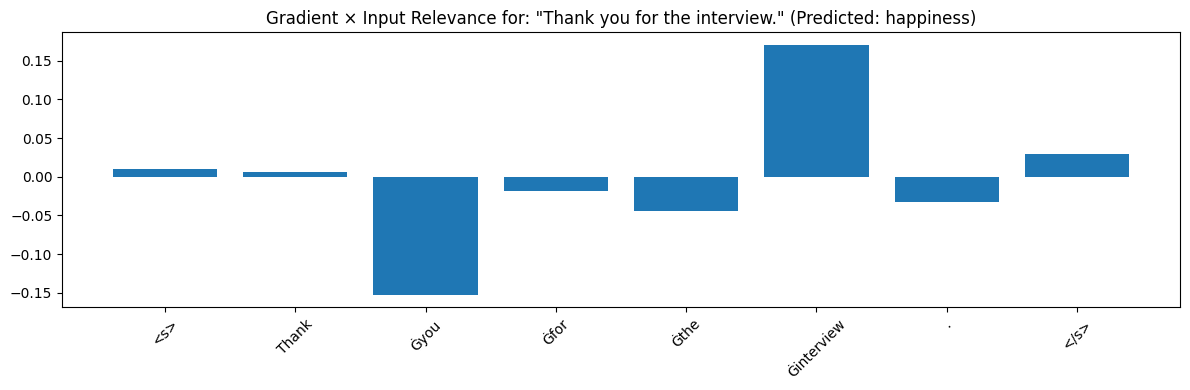

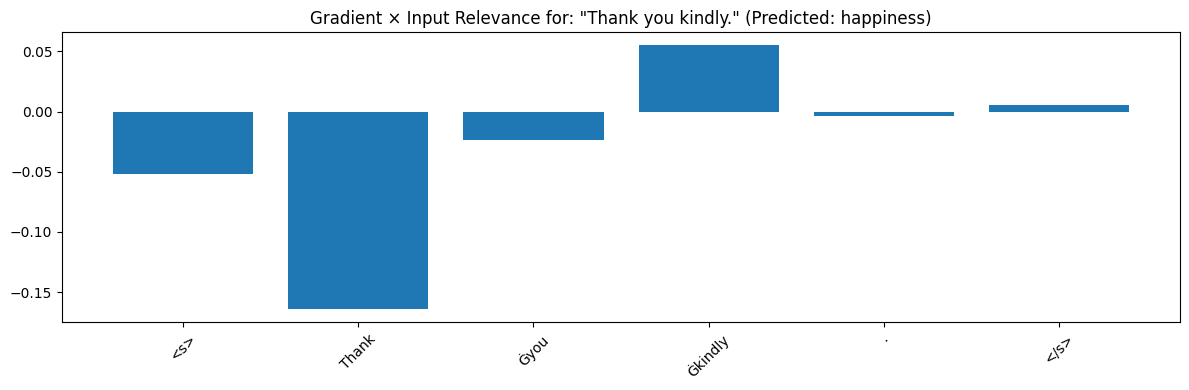

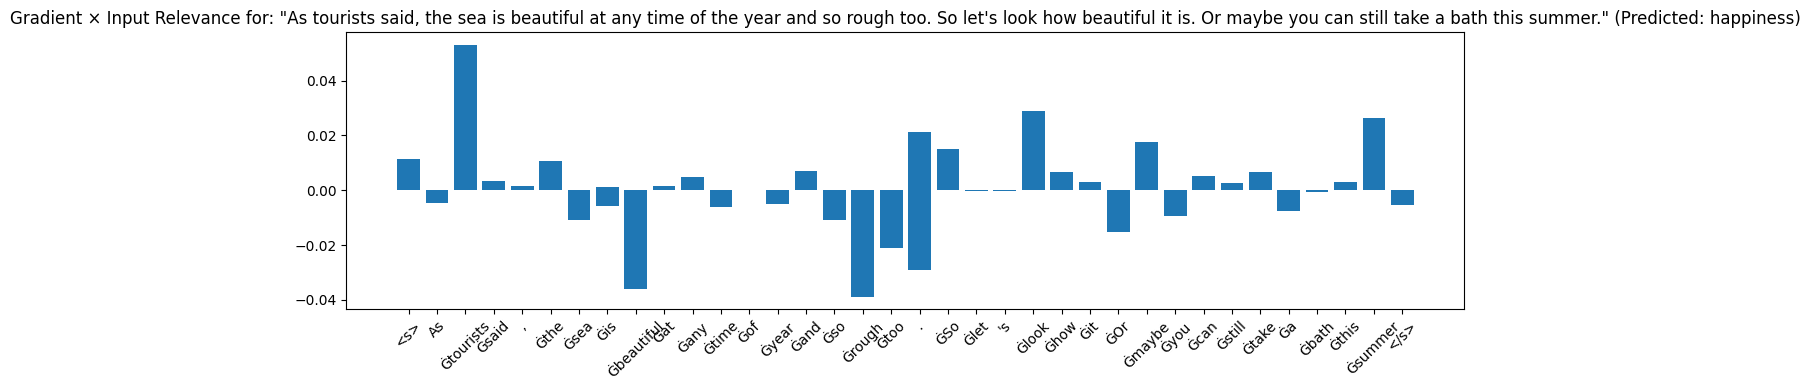

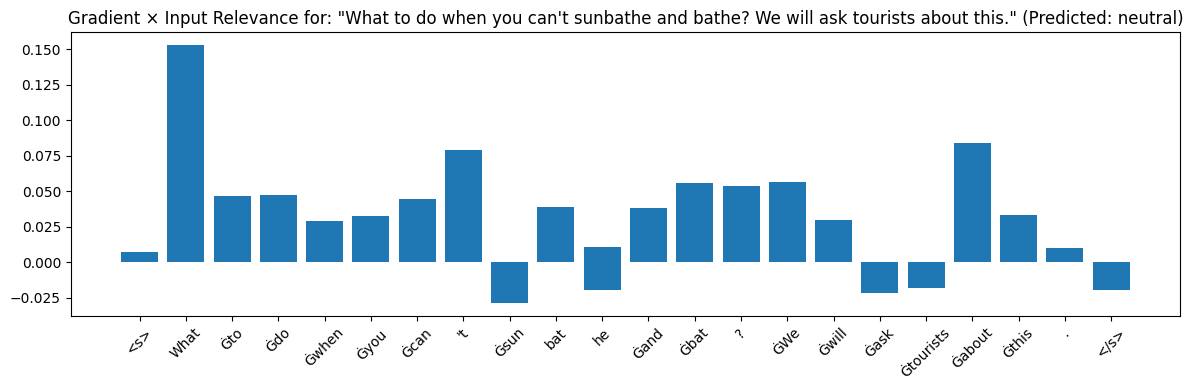

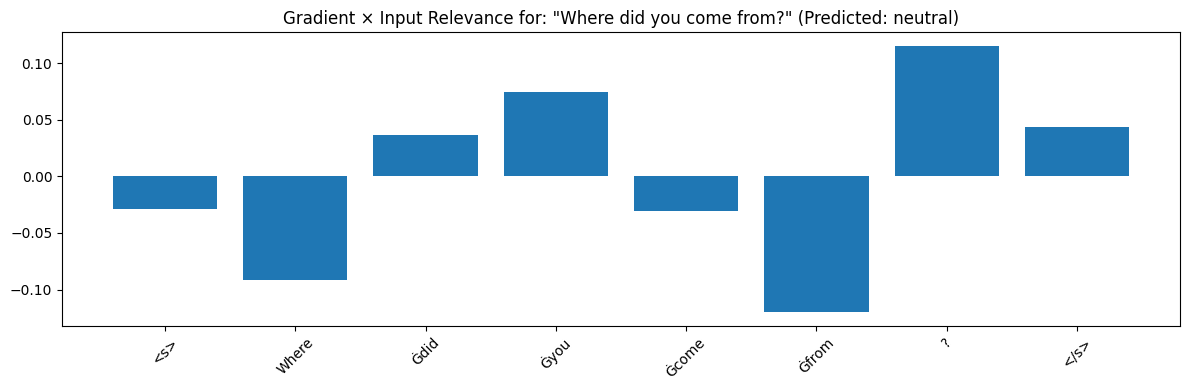

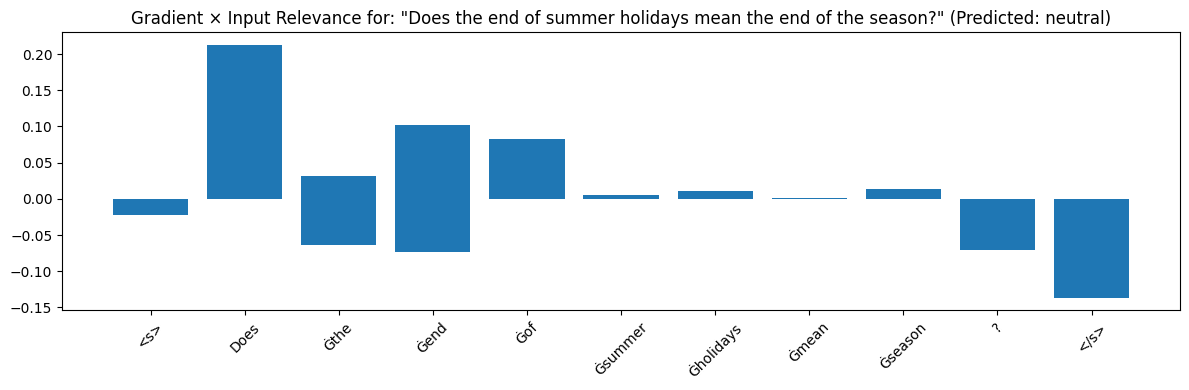

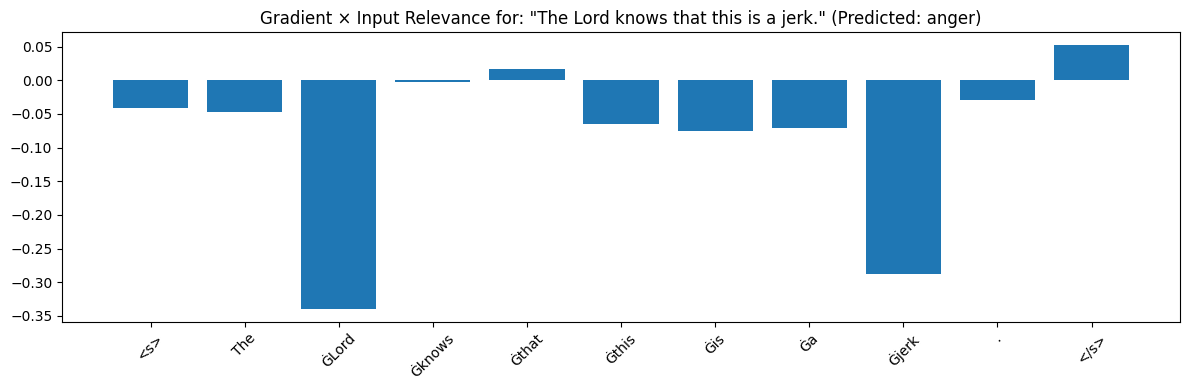

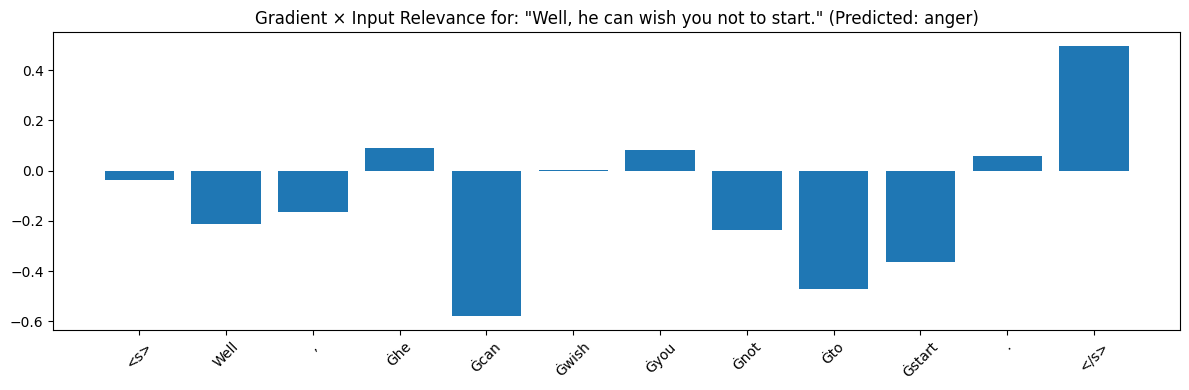

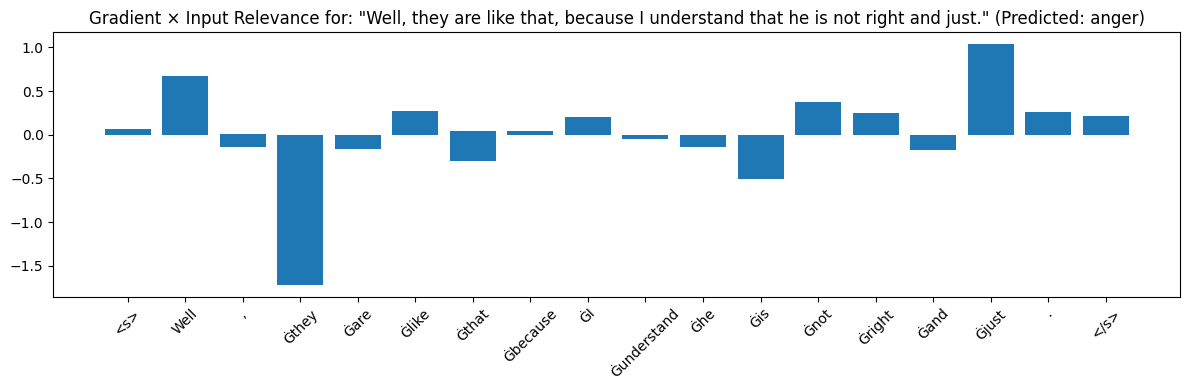

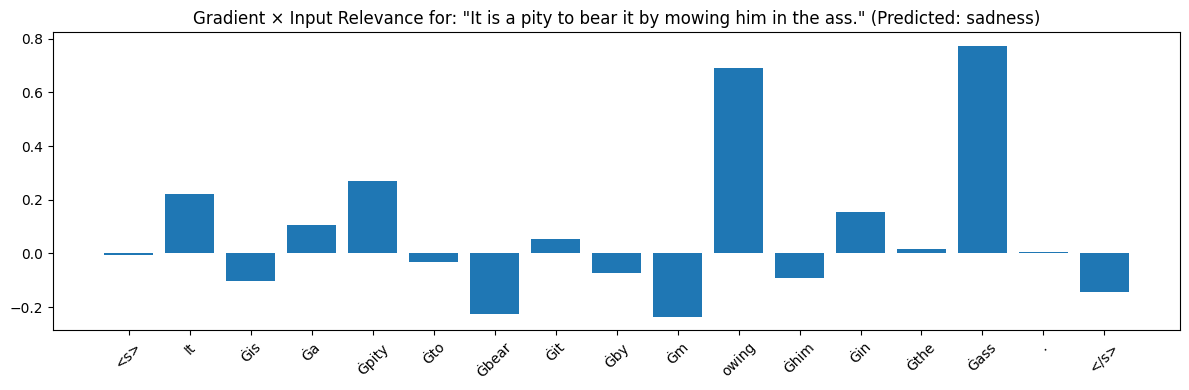

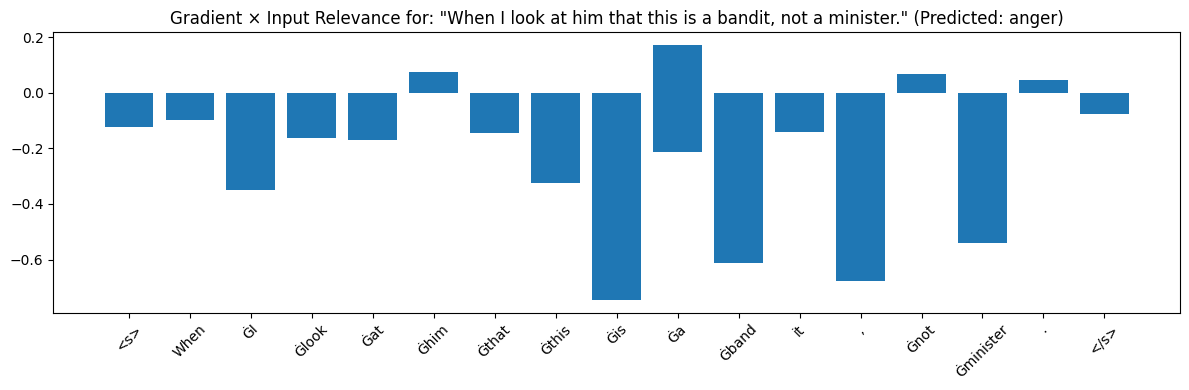

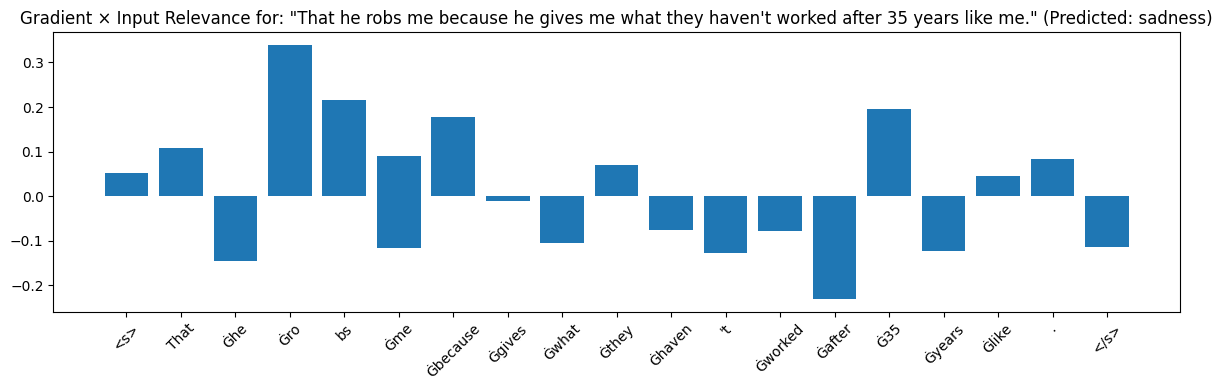

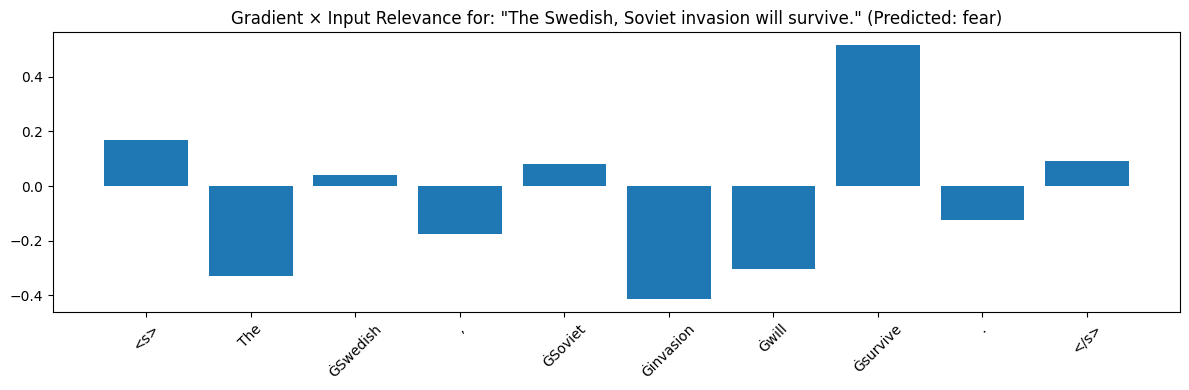

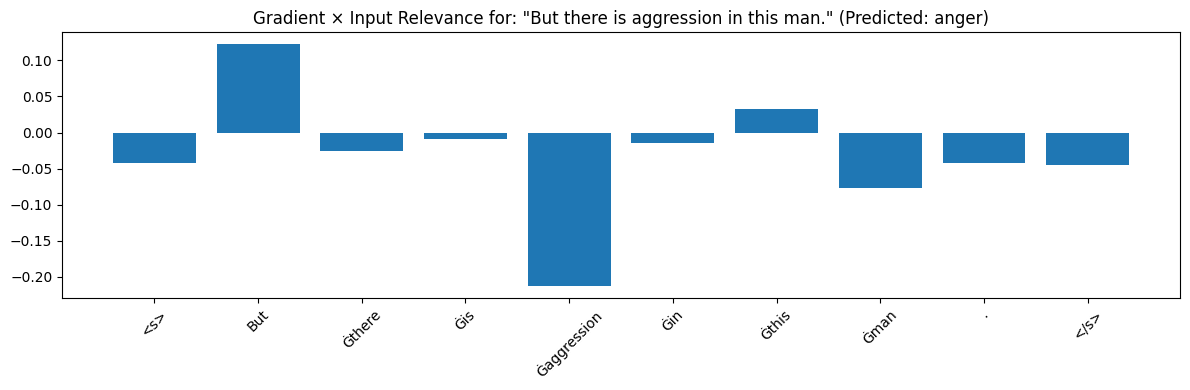

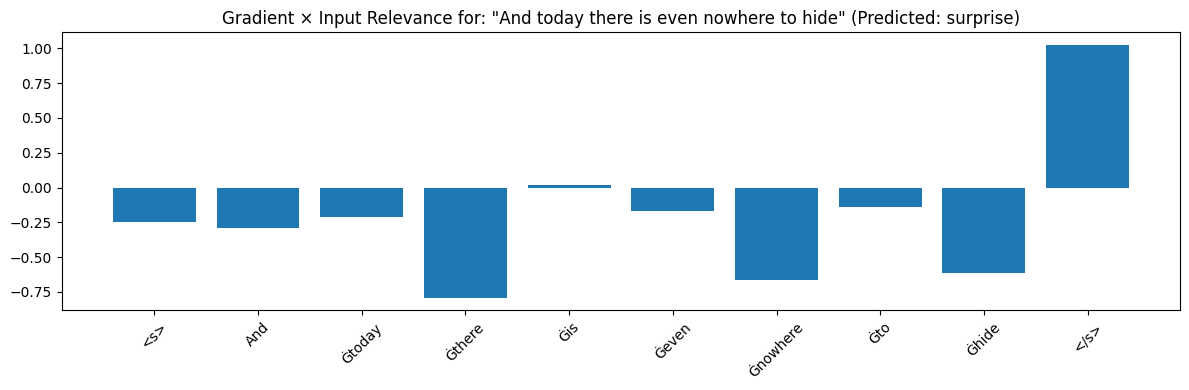

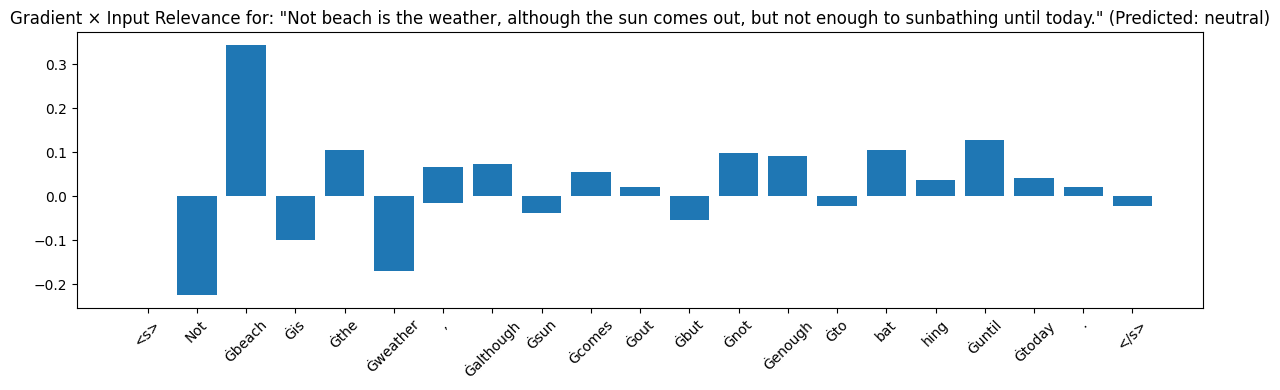

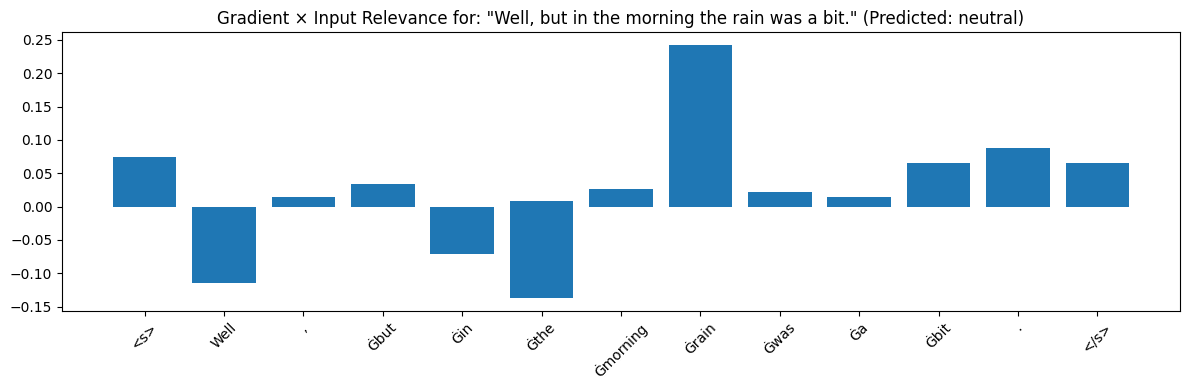

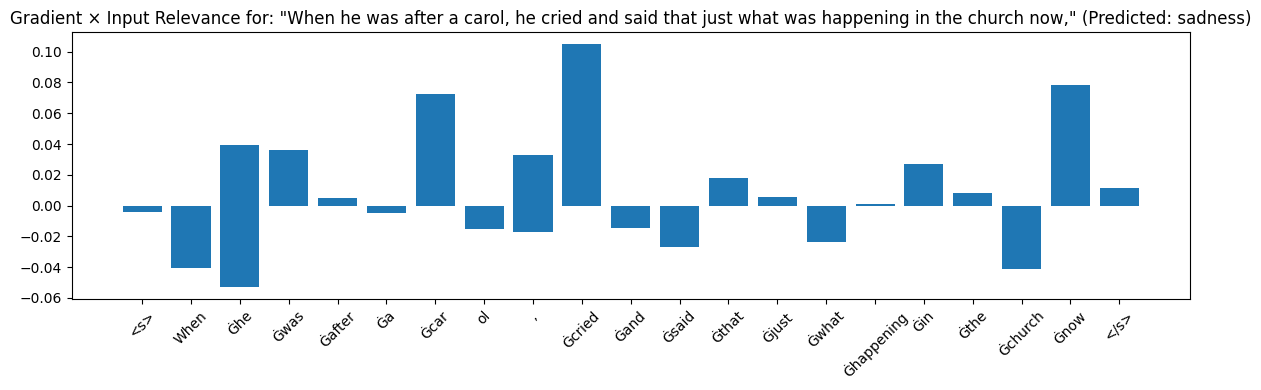

In [6]:
for emotion, sents in sentences.items():
    for sent in sents:
        visualize_gradient_input(model, tokenizer, sent)

# Part 2

In [8]:
from transformers_interpret import SequenceClassificationExplainer

explainer = SequenceClassificationExplainer(
    model=model,
    tokenizer=tokenizer
)


In [14]:
for emotion, sents in sentences.items():
    for sent in sents:
        word_attributions = explainer(sent)
        predicted_class = label_encoder.inverse_transform([explainer.predicted_class_index])[0]
        print(f"Sentence: {sent}")
        print(f"Predicted: {predicted_class}")
        explainer.visualize()


Sentence: Daniel Klusek, welcome to the Promenada studio. We're going.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.75),LABEL_3,1.51,"#s Daniel Kl use k , welcome to the Prom en ada studio . We 're going . #/s"


Sentence: I mean I will swim. At the moment I am on a walk and we will swim at 2pm.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.74),LABEL_3,2.89,#s I mean I will swim . At the moment I am on a walk and we will swim at 2 pm . #/s


Sentence: Good morning.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.65),LABEL_4,1.16,#s Good morning . #/s


Sentence: Thank you for the interview.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.96),LABEL_3,2.16,#s Thank you for the interview . #/s


Sentence: Thank you kindly.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.96),LABEL_3,2.00,#s Thank you kindly . #/s


Sentence: As tourists said, the sea is beautiful at any time of the year and so rough too. So let's look how beautiful it is. Or maybe you can still take a bath this summer.
Predicted: happiness


Sentence: What to do when you can't sunbathe and bathe? We will ask tourists about this.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.74),LABEL_4,2.42,#s What to do when you can 't sun bat he and bat he ? We will ask tourists about this . #/s


Sentence: Where did you come from?
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.83),LABEL_4,1.77,#s Where did you come from ? #/s


Sentence: Does the end of summer holidays mean the end of the season?
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.70),LABEL_4,1.48,#s Does the end of summer holidays mean the end of the season ? #/s


Sentence: The Lord knows that this is a jerk.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.89),LABEL_0,1.33,#s The Lord knows that this is a jerk . #/s


Sentence: Well, he can wish you not to start.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.81),LABEL_4,2.25,"#s Well , he can wish you not to start . #/s"


Sentence: Well, they are like that, because I understand that he is not right and just.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.60),LABEL_4,0.51,"#s Well , they are like that , because I understand that he is not right and just . #/s"


Sentence: It is a pity to bear it by mowing him in the ass.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.36),LABEL_4,0.91,#s It is a pity to bear it by m owing him in the ass . #/s


Sentence: When I look at him that this is a bandit, not a minister.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.42),LABEL_0,0.55,"#s When I look at him that this is a band it , not a minister . #/s"


Sentence: That he robs me because he gives me what they haven't worked after 35 years like me.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.81),LABEL_0,0.90,#s That he ro bs me because he gives me what they haven 't worked after 35 years like me . #/s


Sentence: The Swedish, Soviet invasion will survive.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.77),LABEL_4,1.76,"#s The Swedish , Soviet invasion will survive . #/s"


Sentence: But there is aggression in this man.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.92),LABEL_0,1.90,#s But there is aggression in this man . #/s


Sentence: And today there is even nowhere to hide
Predicted: surprise


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
6,LABEL_6 (0.72),LABEL_6,0.71,#s And today there is even nowhere to hide #/s


Sentence: Not beach is the weather, although the sun comes out, but not enough to sunbathing until today.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.74),LABEL_4,2.32,"#s Not beach is the weather , although the sun comes out , but not enough to sun bat hing until today . #/s"


Sentence: Well, but in the morning the rain was a bit.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.86),LABEL_4,1.52,"#s Well , but in the morning the rain was a bit . #/s"


Sentence: When he was after a carol, he cried and said that just what was happening in the church now,
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.49),LABEL_4,0.89,"#s When he was after a car ol , he cried and said that just what was happening in the church now , #/s"


# Part 3

In [ ]:
def perturb_input_and_plot(model, tokenizer, text, word_attributions):
    tokens = [t[0] for t in word_attributions]
    scores = [abs(t[1]) for t in word_attributions]
    token_score_pairs = list(zip(tokens, scores))

    sorted_tokens = sorted(token_score_pairs, key=lambda x: x[1])

    perturbed_texts = []
    for i in range(1, len(sorted_tokens) + 1):
        perturbed_tokens = tokens[:]
        for j in range(i):
            token_to_remove = sorted_tokens[j][0]
            try:
                idx = perturbed_tokens.index(token_to_remove)
                perturbed_tokens[idx] = tokenizer.pad_token or "<pad>"
            except ValueError:
                continue
        perturbed_text = tokenizer.convert_tokens_to_string(perturbed_tokens)
        perturbed_texts.append(perturbed_text)

    confidences = []
    for pert_text in perturbed_texts:
        inputs = tokenizer(pert_text, return_tensors="pt", truncation=True, padding=True)
        with torch.no_grad():
            outputs = model(**inputs)
        confidence = outputs.logits.softmax(dim=-1).max().item()
        confidences.append(confidence)

    plt.figure(figsize=(12, 5))
    plt.plot(range(1, len(confidences) + 1), confidences, marker='o', color='blue')
    plt.axhline(y=0.5, color='red', linestyle='--', label="50% Confidence Threshold")
    plt.fill_between(
        range(1, len(confidences) + 1),
        confidences,
        0.5,
        where=(np.array(confidences) < 0.5),
        color='red',
        alpha=0.2
    )
    plt.title(f"Model Confidence Drop\n\"{text}\"")
    plt.xlabel("Number of Tokens Removed")
    plt.ylabel("Prediction Confidence")
    plt.legend()
    plt.tight_layout()
    plt.show()
 

Sentence: Daniel Klusek, welcome to the Promenada studio. We're going.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.75),LABEL_3,1.51,"#s Daniel Kl use k , welcome to the Prom en ada studio . We 're going . #/s"


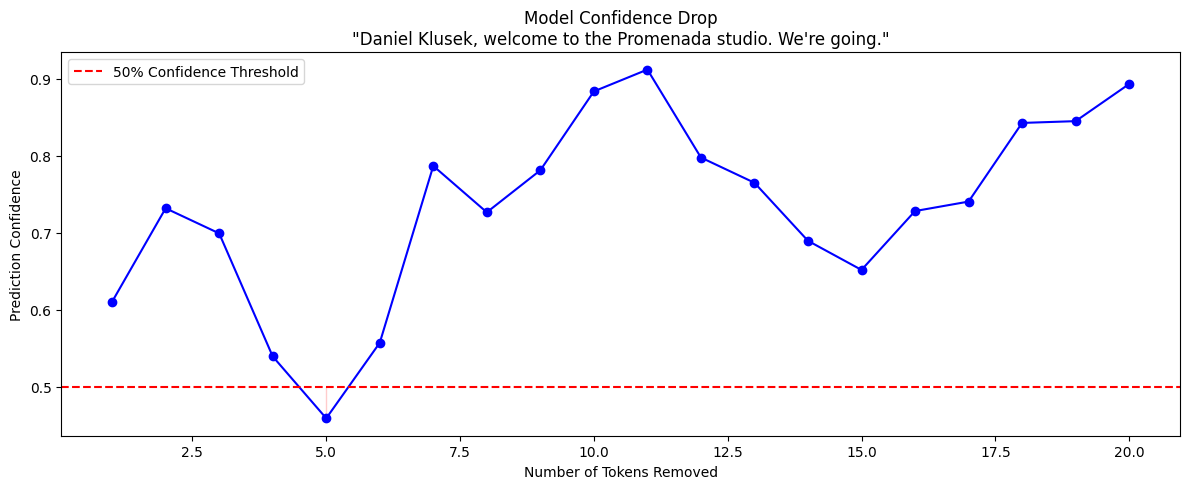

Sentence: I mean I will swim. At the moment I am on a walk and we will swim at 2pm.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.74),LABEL_3,2.89,#s I mean I will swim . At the moment I am on a walk and we will swim at 2 pm . #/s


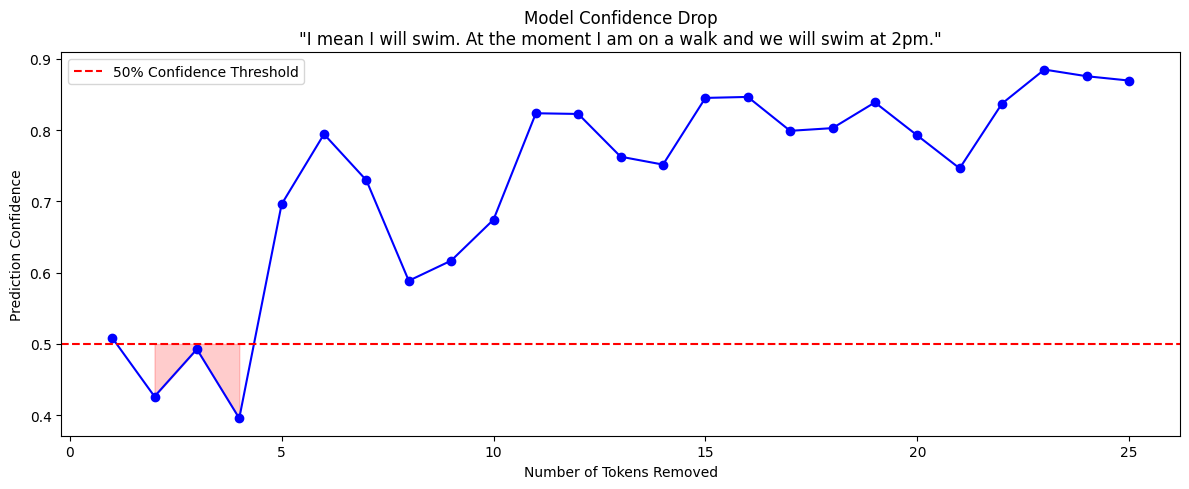

Sentence: Good morning.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.65),LABEL_4,1.16,#s Good morning . #/s


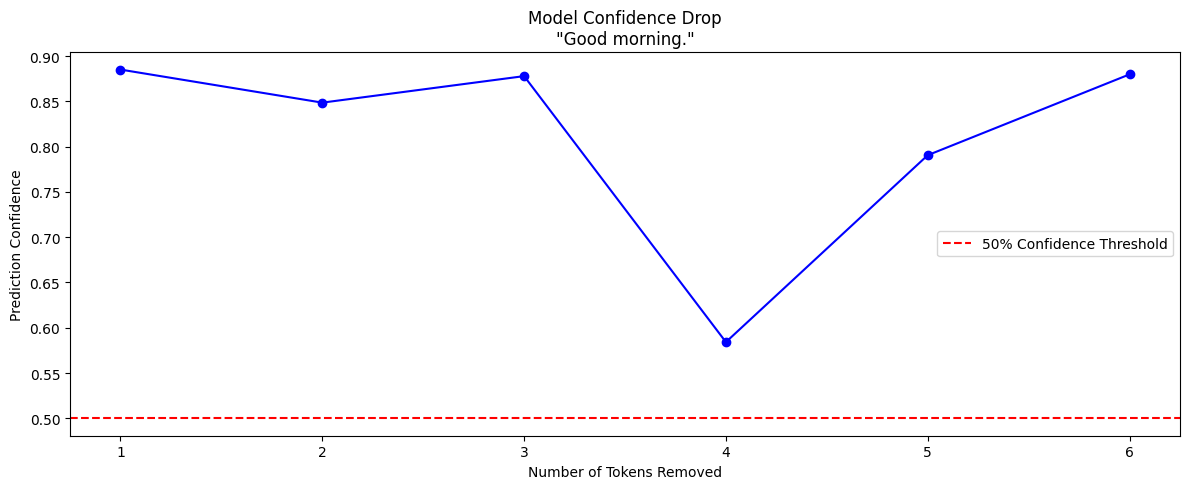

Sentence: Thank you for the interview.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.96),LABEL_3,2.16,#s Thank you for the interview . #/s


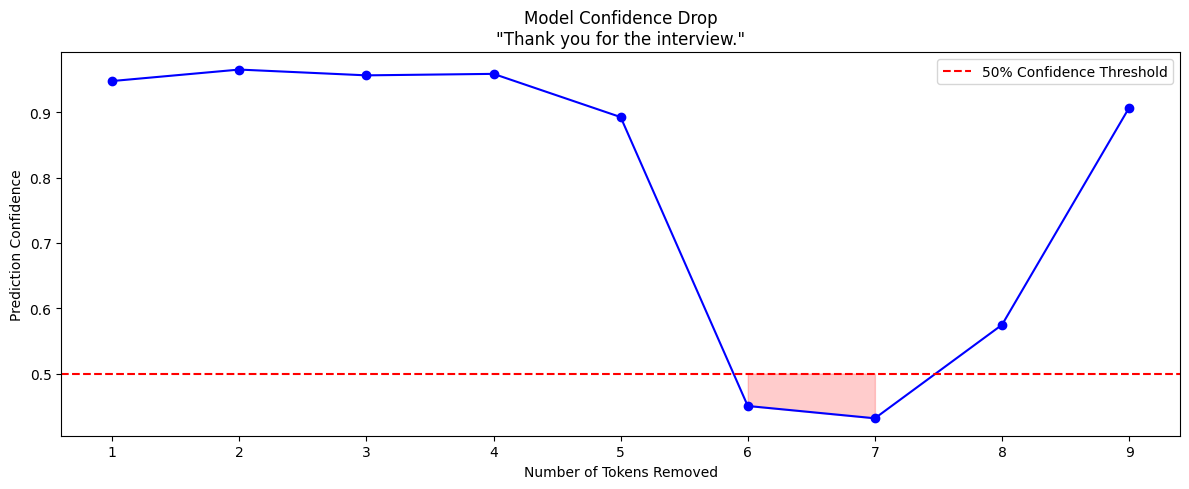

Sentence: Thank you kindly.
Predicted: happiness


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
3,LABEL_3 (0.96),LABEL_3,2.00,#s Thank you kindly . #/s


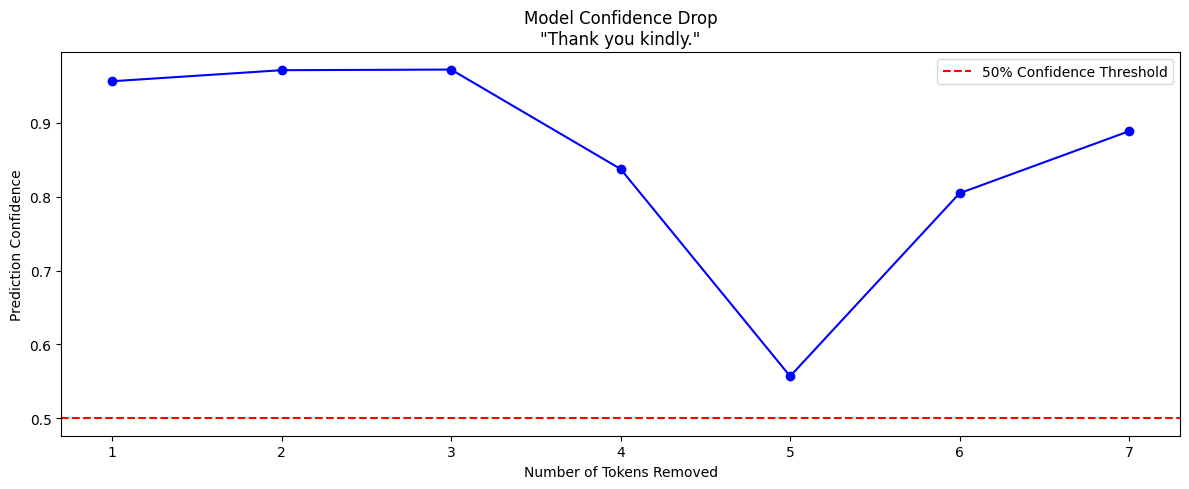

Sentence: As tourists said, the sea is beautiful at any time of the year and so rough too. So let's look how beautiful it is. Or maybe you can still take a bath this summer.
Predicted: happiness


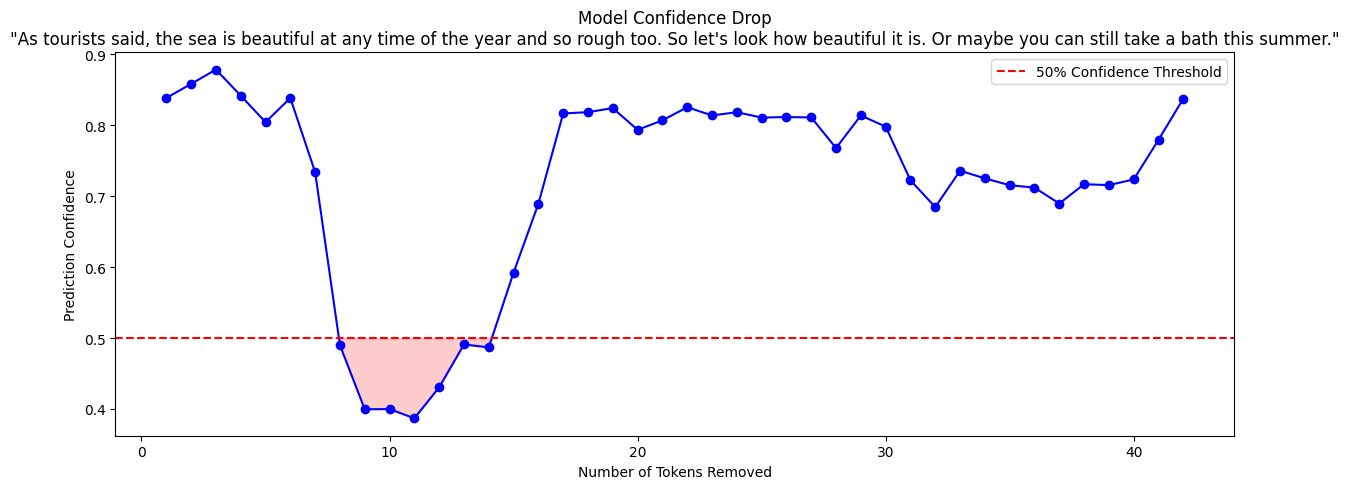

Sentence: What to do when you can't sunbathe and bathe? We will ask tourists about this.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.74),LABEL_4,2.42,#s What to do when you can 't sun bat he and bat he ? We will ask tourists about this . #/s


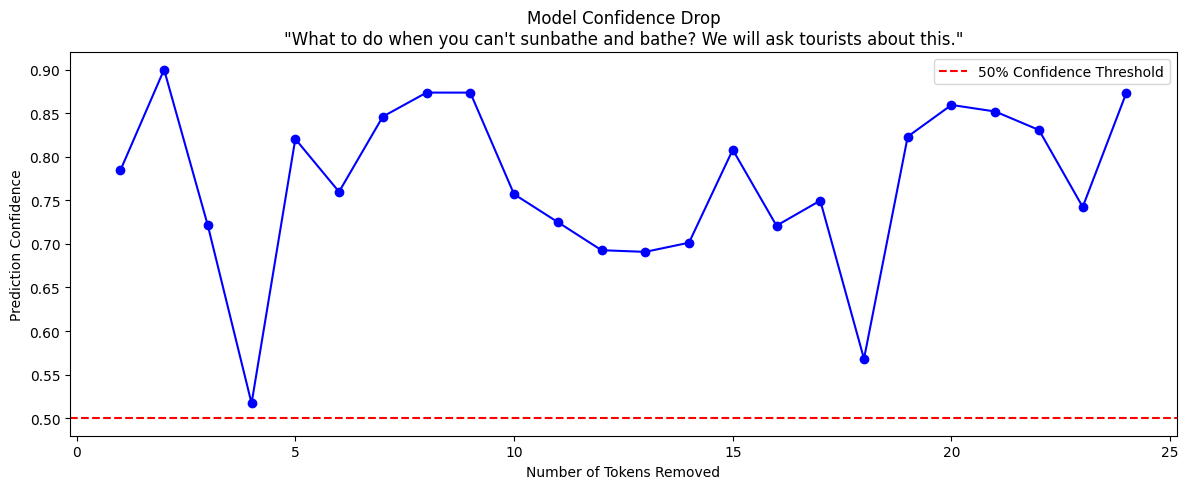

Sentence: Where did you come from?
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.83),LABEL_4,1.77,#s Where did you come from ? #/s


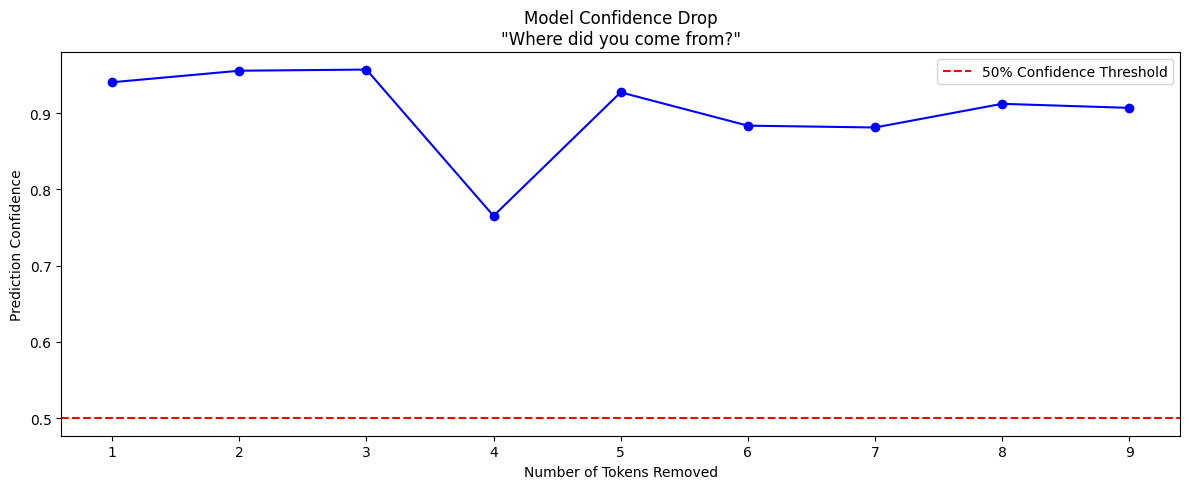

Sentence: Does the end of summer holidays mean the end of the season?
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.70),LABEL_4,1.48,#s Does the end of summer holidays mean the end of the season ? #/s


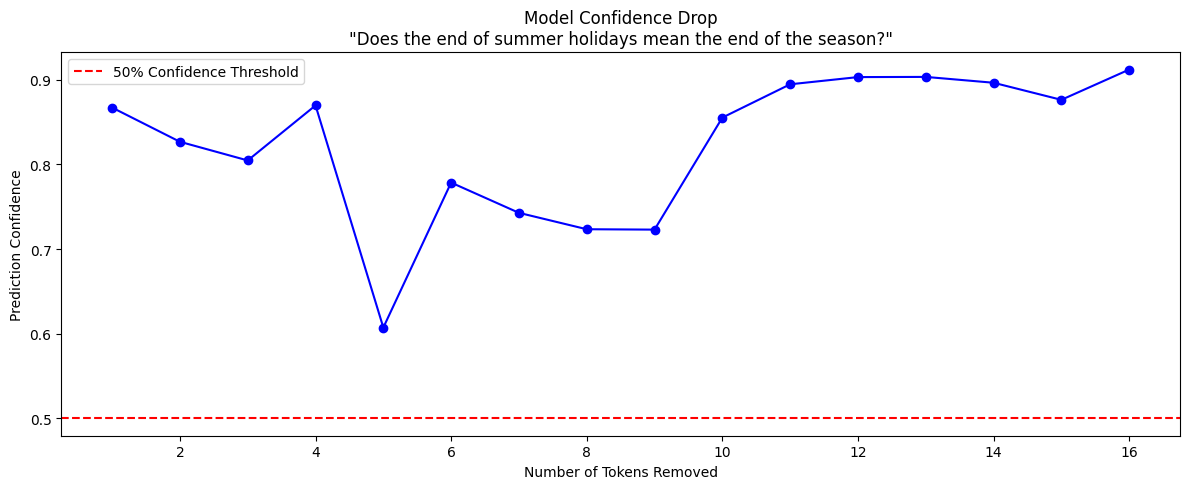

Sentence: The Lord knows that this is a jerk.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.89),LABEL_0,1.33,#s The Lord knows that this is a jerk . #/s


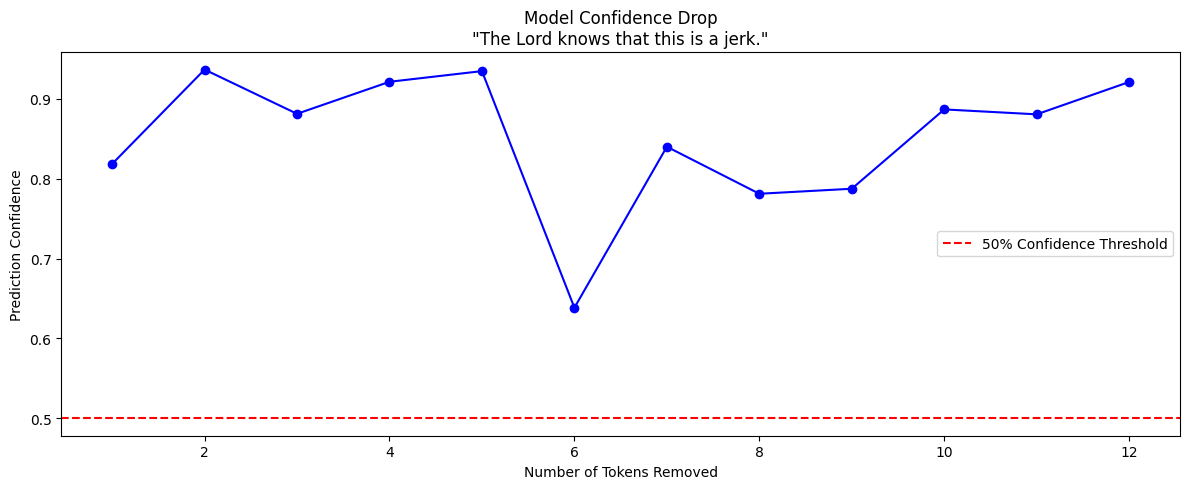

Sentence: Well, he can wish you not to start.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.81),LABEL_4,2.25,"#s Well , he can wish you not to start . #/s"


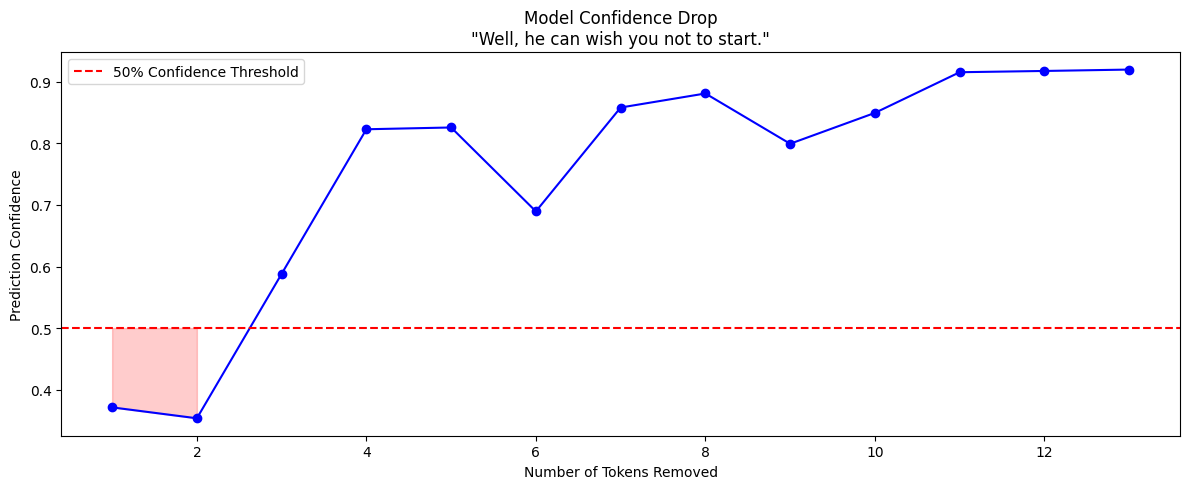

Sentence: Well, they are like that, because I understand that he is not right and just.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.60),LABEL_4,0.51,"#s Well , they are like that , because I understand that he is not right and just . #/s"


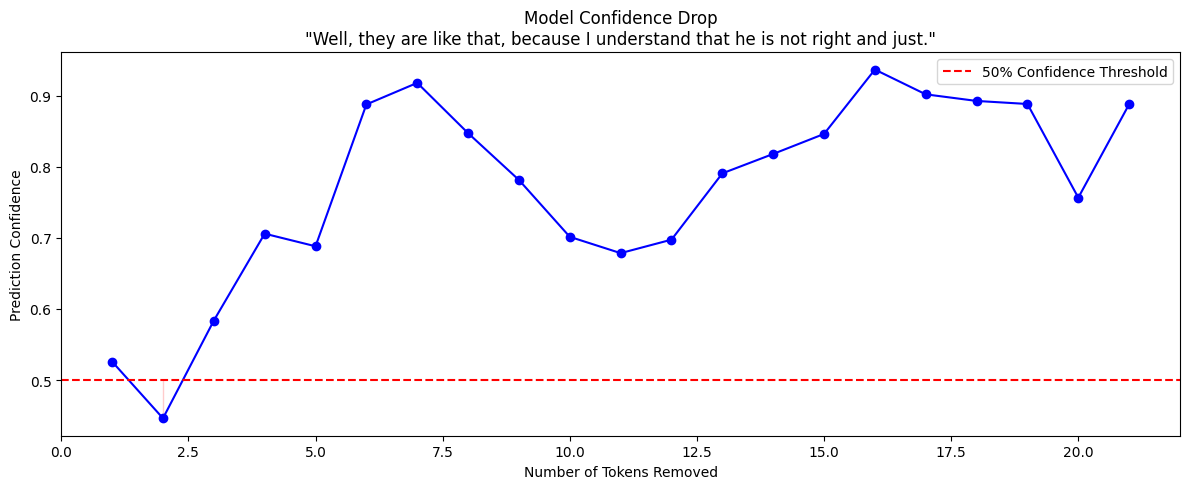

Sentence: It is a pity to bear it by mowing him in the ass.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.36),LABEL_4,0.91,#s It is a pity to bear it by m owing him in the ass . #/s


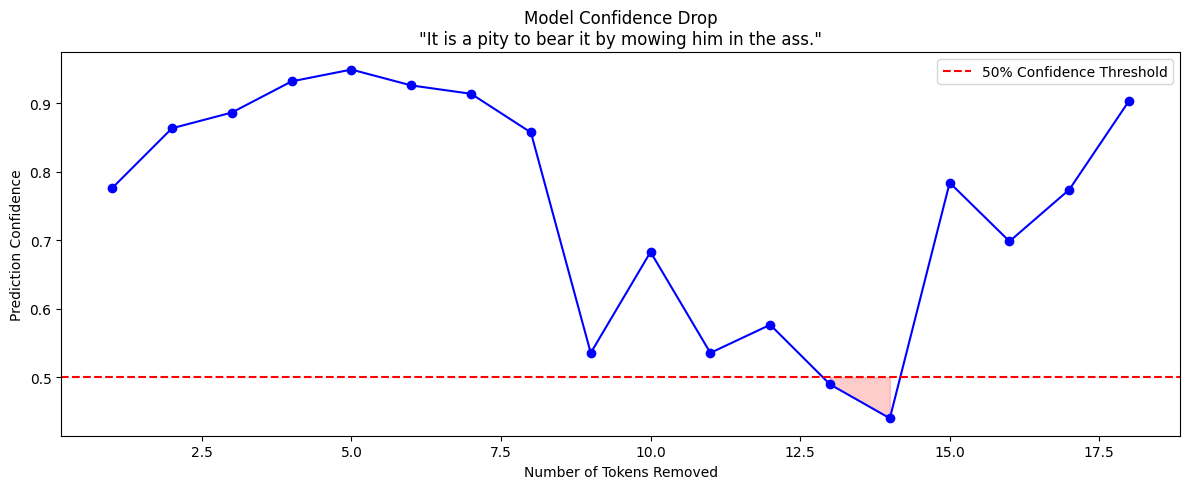

Sentence: When I look at him that this is a bandit, not a minister.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.42),LABEL_0,0.55,"#s When I look at him that this is a band it , not a minister . #/s"


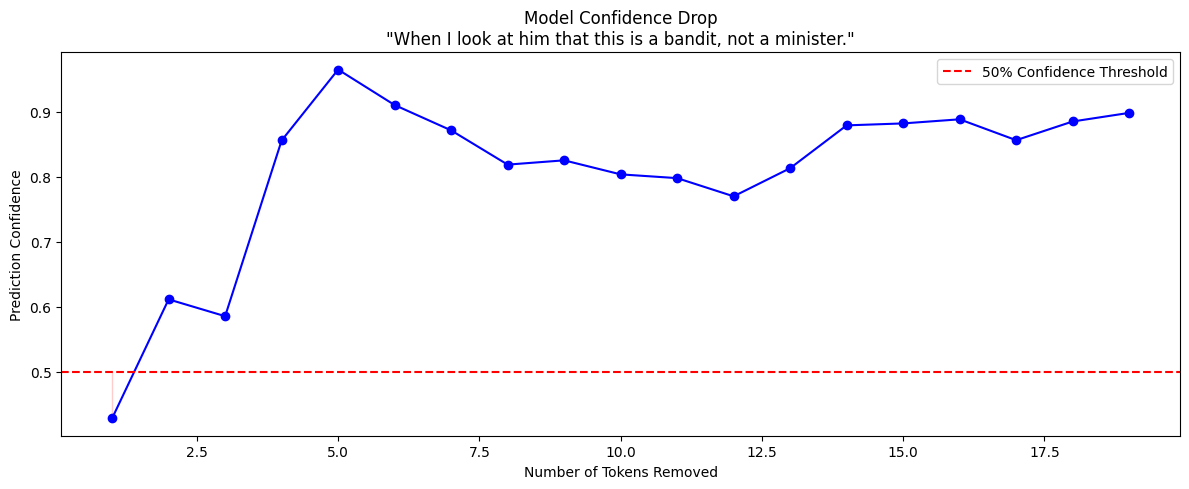

Sentence: That he robs me because he gives me what they haven't worked after 35 years like me.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.81),LABEL_0,0.90,#s That he ro bs me because he gives me what they haven 't worked after 35 years like me . #/s


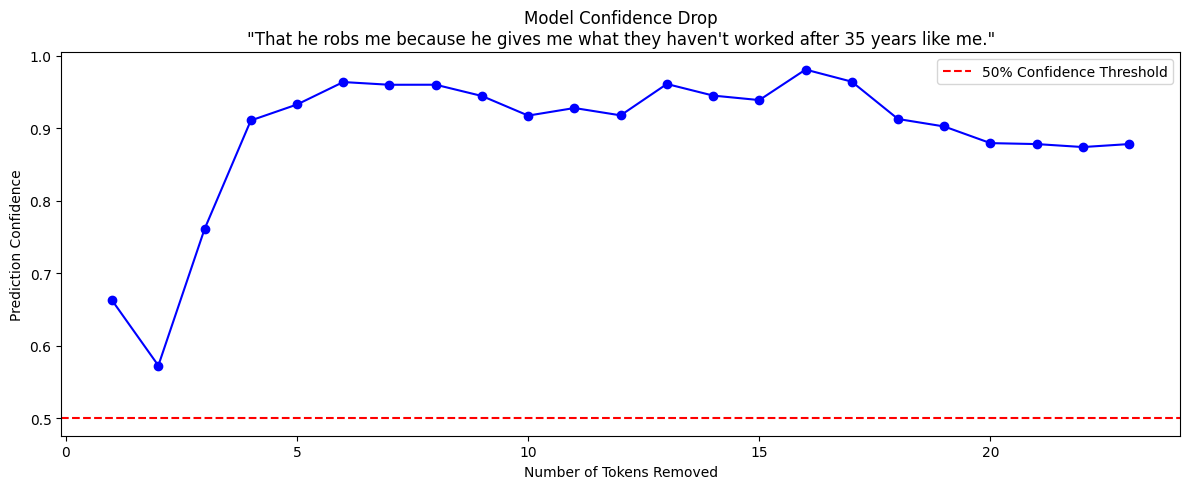

Sentence: The Swedish, Soviet invasion will survive.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.77),LABEL_4,1.76,"#s The Swedish , Soviet invasion will survive . #/s"


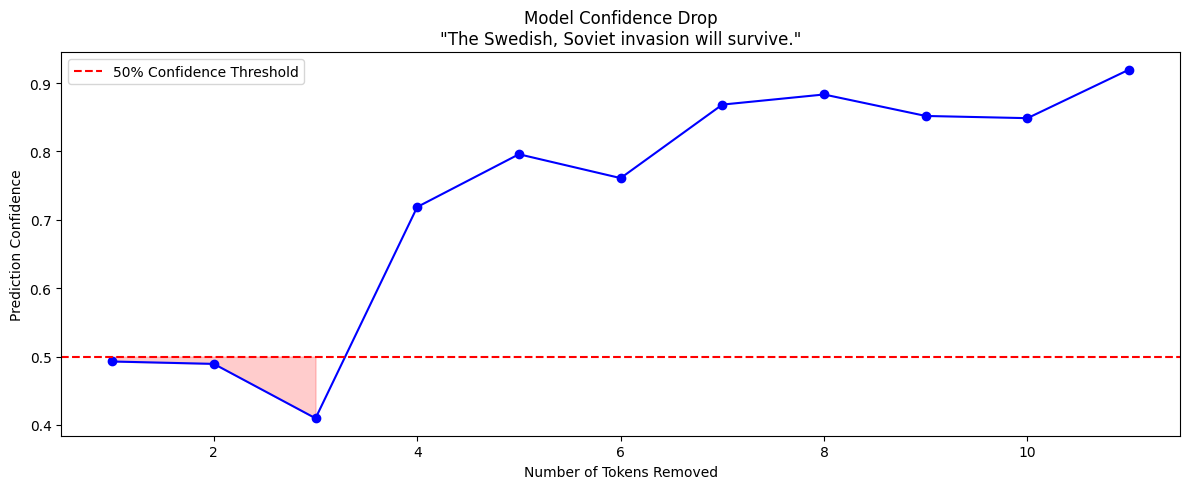

Sentence: But there is aggression in this man.
Predicted: anger


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,LABEL_0 (0.92),LABEL_0,1.90,#s But there is aggression in this man . #/s


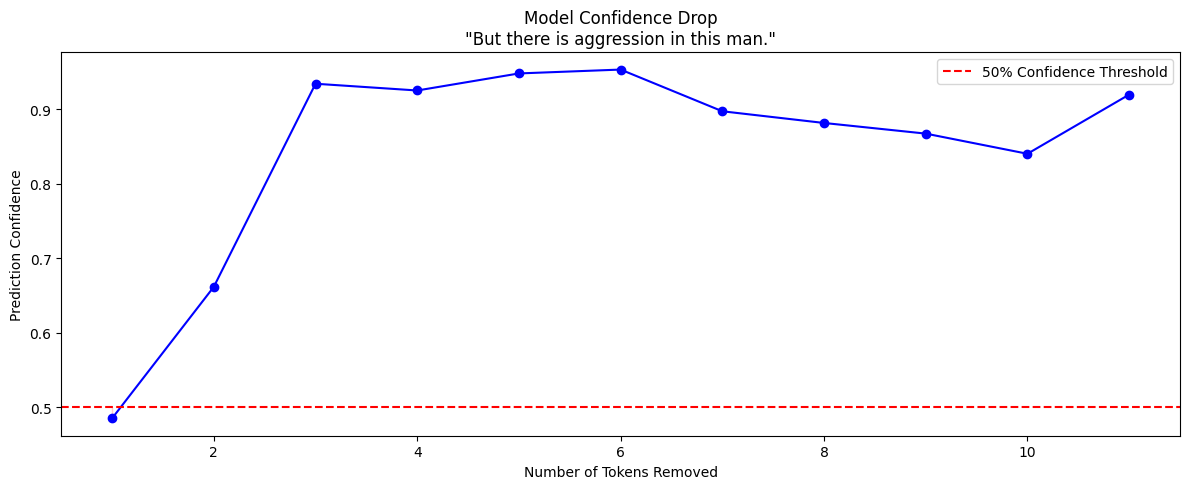

Sentence: And today there is even nowhere to hide
Predicted: surprise


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
6,LABEL_6 (0.72),LABEL_6,0.71,#s And today there is even nowhere to hide #/s


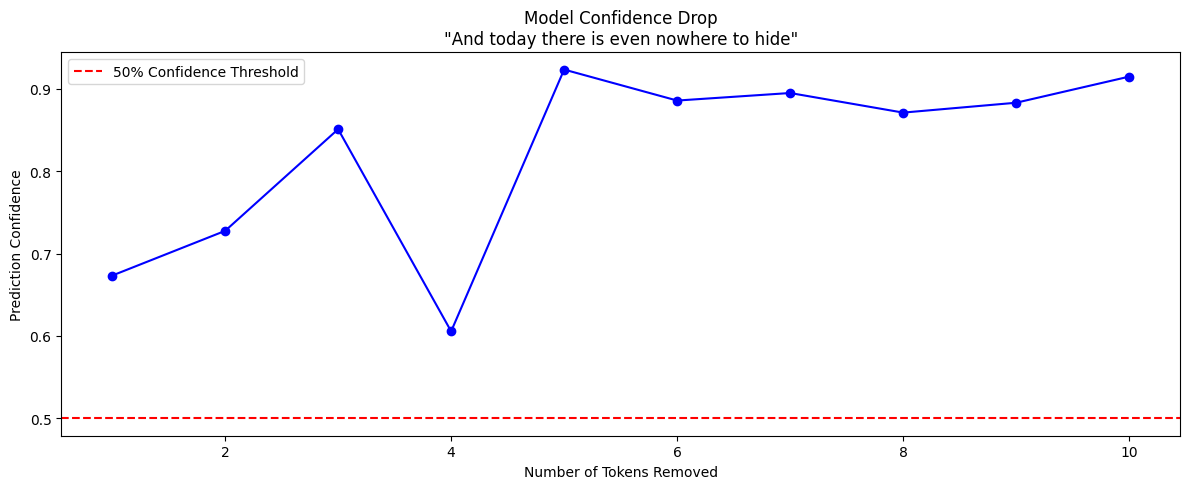

Sentence: Not beach is the weather, although the sun comes out, but not enough to sunbathing until today.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.74),LABEL_4,2.32,"#s Not beach is the weather , although the sun comes out , but not enough to sun bat hing until today . #/s"


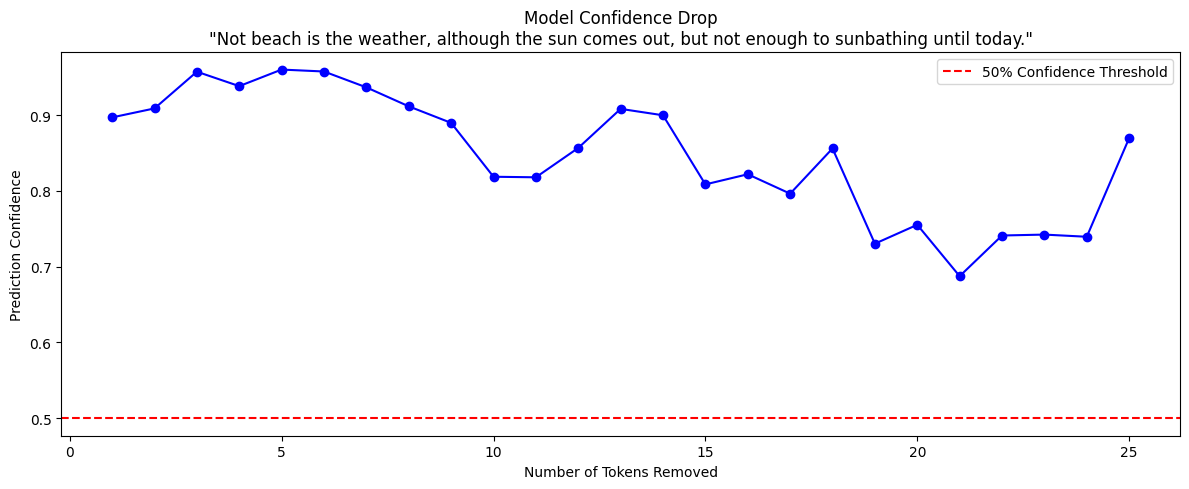

Sentence: Well, but in the morning the rain was a bit.
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.86),LABEL_4,1.52,"#s Well , but in the morning the rain was a bit . #/s"


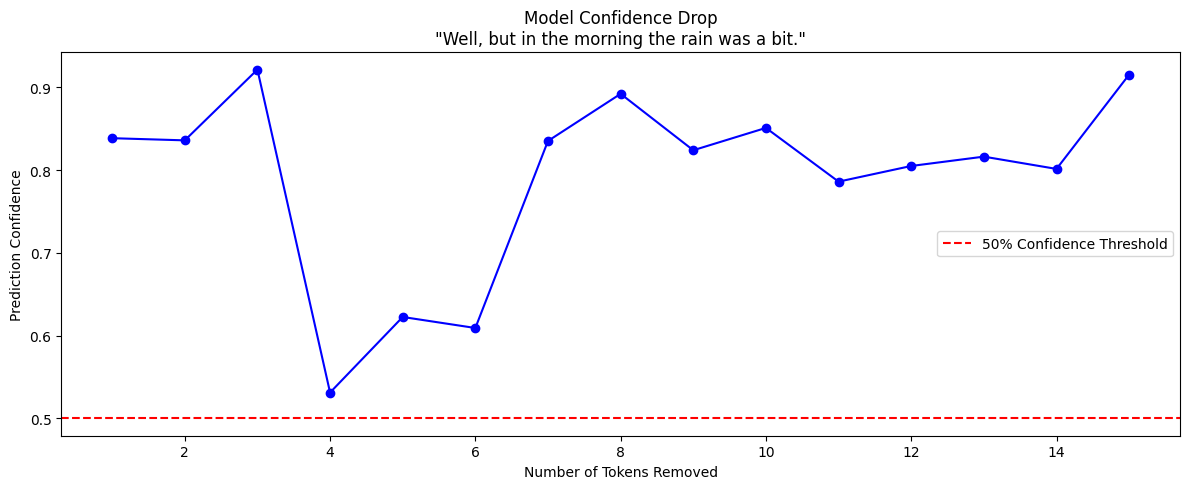

Sentence: When he was after a carol, he cried and said that just what was happening in the church now,
Predicted: neutral


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
4,LABEL_4 (0.49),LABEL_4,0.89,"#s When he was after a car ol , he cried and said that just what was happening in the church now , #/s"


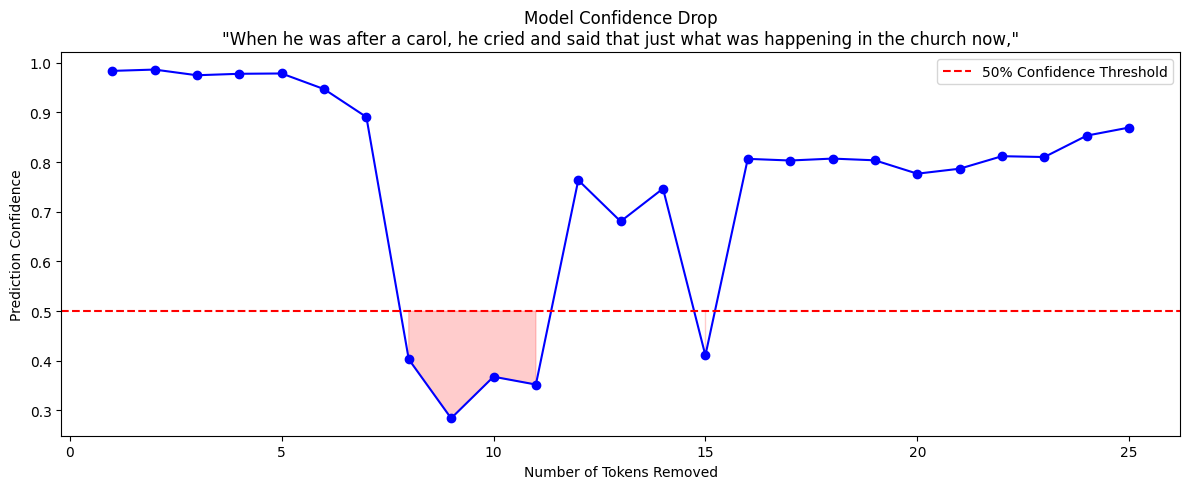

In [18]:
for emotion, sents in sentences.items():
    for sent in sents:
        word_attributions = explainer(sent)
        predicted_class = label_encoder.inverse_transform([explainer.predicted_class_index])[0]
        print(f"Sentence: {sent}")
        print(f"Predicted: {predicted_class}")
        explainer.visualize()

        perturb_input_and_plot(model, tokenizer, sent, word_attributions)
